# **MNIST Handwritten Digits Classification**
A FCNN (Fully Connected Neural Network) and CNN (Convolutional Nerual Network) have been modeled

## Import required packages

In [1]:
import numpy as np 
import torch 
from torchvision import datasets,transforms
import matplotlib.pyplot as plt 
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Defining our Transforms

In [2]:
transform=transforms.Compose([transforms.ToTensor()])

## Gathering the train and test data


In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transform)
test_data=datasets.MNIST('data',train=False,download=True,transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Defining our Train, Valid and Test Dataloaders

In [4]:
valid_size=0.2
batch_size=20
num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [5]:
# This is for debugging
train_idx.__len__(),valid_idx.__len__()

(48000, 12000)

In [6]:
# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [7]:

# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

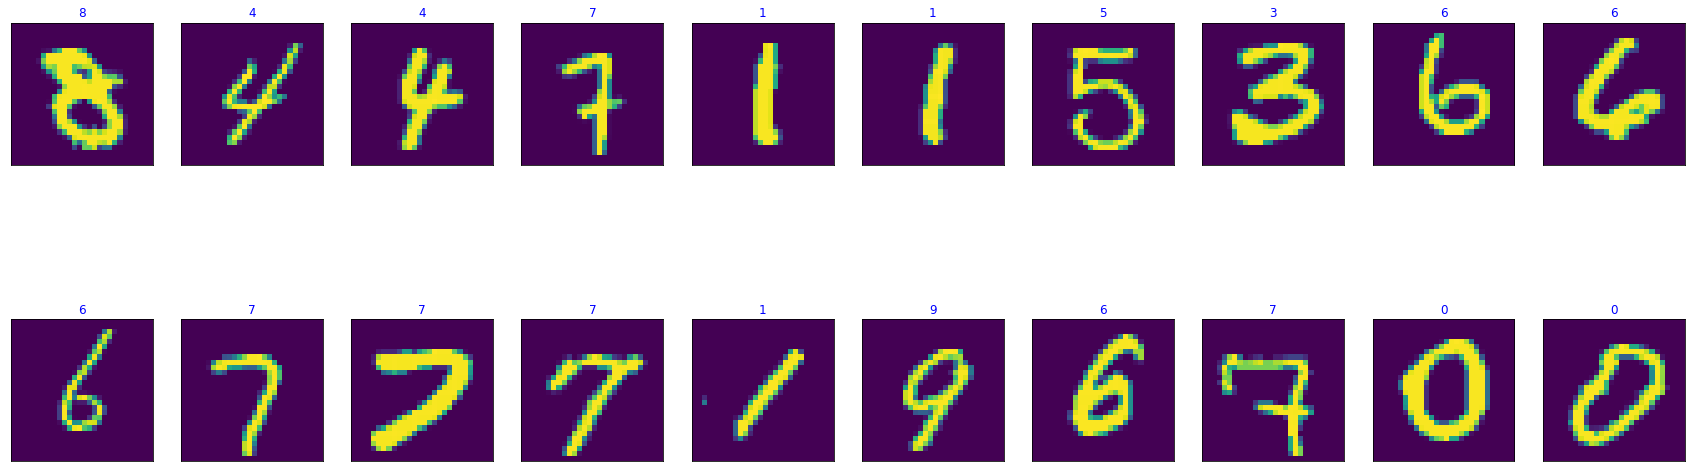

In [8]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

## Defining our Neural Net Architecture

In [9]:

# Model 1 : This model has dropout set to a certain value
# NOTE : When we want to use dropout we ensure we run train() method on our model --- during training , if not required we should use eval() method --- validation and testing
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        
        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)        
        x=self.dropout(torch.sigmoid(self.fc1(x)))
        x=self.dropout(torch.sigmoid(self.fc2(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x
    

In [10]:
model_1=FNet()
model_2=convNet()

use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()


print(model_1,'\n\n\n\n',model_2,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  True


## Defining our Loss Function

In [11]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()


## Training and Validation Phase

In [12]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
        z=type(model).__name__
        torch.save(model.state_dict(), z+'_model.pth')
        valid_loss_min=valid_loss
    return(loss_keeper)

In [13]:
m1_loss=trainNet(model_1,0.001)


Epoch : 1	Training Loss : 0.39812957840040325	Validation Loss : 0.18842560219888885
Validation loss decreased from : inf ----> 0.18842560219888885 ----> Saving Model.......

Epoch : 2	Training Loss : 0.15855457877371615	Validation Loss : 0.1233623548624261
Validation loss decreased from : 0.18842560219888885 ----> 0.1233623548624261 ----> Saving Model.......

Epoch : 3	Training Loss : 0.1123578728857198	Validation Loss : 0.09879512050654739
Validation loss decreased from : 0.1233623548624261 ----> 0.09879512050654739 ----> Saving Model.......

Epoch : 4	Training Loss : 0.0831171301290063	Validation Loss : 0.08819278451866315
Validation loss decreased from : 0.09879512050654739 ----> 0.08819278451866315 ----> Saving Model.......

Epoch : 5	Training Loss : 0.06516427677675286	Validation Loss : 0.0813408897890137
Validation loss decreased from : 0.08819278451866315 ----> 0.0813408897890137 ----> Saving Model.......

Epoch : 6	Training Loss : 0.05316900384443822	Validation Loss : 0.078248

In [14]:
m1_loss

{'train': [0.39812957840040325,
  0.15855457877371615,
  0.1123578728857198,
  0.0831171301290063,
  0.06516427677675286,
  0.05316900384443822,
  0.044032152658001,
  0.033821693612396,
  0.029663057859264274,
  0.026385591837253818,
  0.023324077449622487,
  0.018542224921922448,
  0.019152381825468676,
  0.016071207148295248,
  0.016260416316874284,
  0.01431226617189381,
  0.013205994847114393,
  0.012045677795649563,
  0.01097653500048267,
  0.010266864207148991],
 'valid': [0.18842560219888885,
  0.1233623548624261,
  0.09879512050654739,
  0.08819278451866315,
  0.0813408897890137,
  0.0782483825693392,
  0.07523465906160709,
  0.077205797862019,
  0.07876117403697208,
  0.0860669793769072,
  0.07744707628407013,
  0.08203894180981328,
  0.08616065819571,
  0.08426182968701444,
  0.08481710982371547,
  0.08378576492717192,
  0.08933375532731769,
  0.0887473424641351,
  0.08942496725841105,
  0.09925672962747228]}

In [15]:
m2_loss=trainNet(model_2,0.001)


Epoch : 1	Training Loss : 0.17067575342150423	Validation Loss : 0.07380096489679999
Validation loss decreased from : inf ----> 0.07380096489679999 ----> Saving Model.......

Epoch : 2	Training Loss : 0.06016434933568386	Validation Loss : 0.056256127632277636
Validation loss decreased from : 0.07380096489679999 ----> 0.056256127632277636 ----> Saving Model.......

Epoch : 3	Training Loss : 0.04289389896486455	Validation Loss : 0.03952241308797966
Validation loss decreased from : 0.056256127632277636 ----> 0.03952241308797966 ----> Saving Model.......

Epoch : 4	Training Loss : 0.033716550319948815	Validation Loss : 0.036523041940170815
Validation loss decreased from : 0.03952241308797966 ----> 0.036523041940170815 ----> Saving Model.......

Epoch : 5	Training Loss : 0.027053823510296268	Validation Loss : 0.04760603731693209

Epoch : 6	Training Loss : 0.02095630887865114	Validation Loss : 0.04317293880223138
Validation loss decreased from : 0.04760603731693209 ----> 0.04317293880223138 

In [16]:
m2_loss

{'train': [0.17067575342150423,
  0.06016434933568386,
  0.04289389896486455,
  0.033716550319948815,
  0.027053823510296268,
  0.02095630887865114,
  0.020507803223410413,
  0.017218128505161488,
  0.01621556945946172,
  0.014355469534677609,
  0.014586137863281277,
  0.012741386846813828,
  0.011294351843325284,
  0.012260205085473075,
  0.01228622874715008,
  0.007447465339365366,
  0.009762229051447297,
  0.010961654564806607,
  0.007803924702685444,
  0.00721608186309148],
 'valid': [0.07380096489679999,
  0.056256127632277636,
  0.03952241308797966,
  0.036523041940170815,
  0.04760603731693209,
  0.04317293880223138,
  0.037269772860777796,
  0.06259447048779058,
  0.04858343566458203,
  0.04778457841114188,
  0.04472750445312552,
  0.06412164205832846,
  0.04743464589453046,
  0.06330024014302066,
  0.05531173189442403,
  0.06705708797477276,
  0.09135616438277876,
  0.05432628309967505,
  0.0658334824504675,
  0.0628716492530031]}

## Loading model from Lowest Validation Loss

In [17]:
# Loading the model from the lowest validation loss 
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))


<All keys matched successfully>

In [18]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


## Plotting Training and Validation Losses

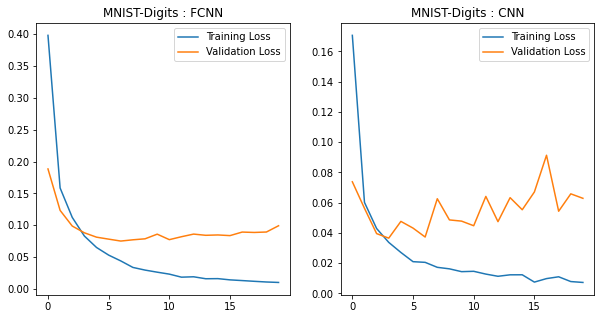

In [19]:
title=['FCNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('MNIST-Digits : '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [20]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss=test_loss/len(train_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {i} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

## Visualizing a Test batch with results

### FCNN

For FNet :
Test Loss: 0.01826852568133323
Correctly predicted per class : [970.0, 1128.0, 1019.0, 998.0, 947.0, 865.0, 938.0, 1005.0, 949.0, 994.0], Total correctly perdicted : 9813.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 98.9795918367347% where 970 of 980 were predicted correctly
Test Accuracy of class 1 : 99.38325991189427% where 1128 of 1135 were predicted correctly
Test Accuracy of class 2 : 98.74031007751938% where 1019 of 1032 were predicted correctly
Test Accuracy of class 3 : 98.81188118811882% where 998 of 1010 were predicted correctly
Test Accuracy of class 4 : 96.43584521384929% where 947 of 982 were predicted correctly
Test Accuracy of class 5 : 96.97309417040358% where 865 of 892 were predicted correctly
Test Accuracy of class 6 : 97.91231732776617% where 938 of 958 were predicted correctly
Test Accuracy of class 7 : 97.76264591439688% whe

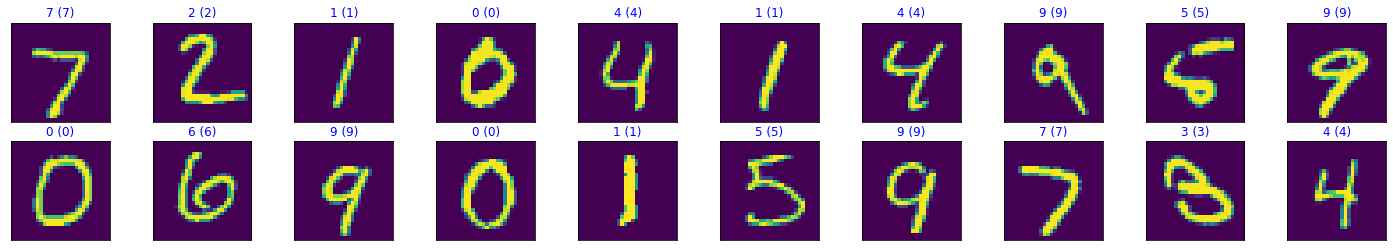

In [21]:
test(model_1)

### CNN

For convNet :
Test Loss: 0.010896420856374966
Correctly predicted per class : [977.0, 1132.0, 1028.0, 1006.0, 966.0, 886.0, 949.0, 1016.0, 969.0, 984.0], Total correctly perdicted : 9913.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 99.6938775510204% where 977 of 980 were predicted correctly
Test Accuracy of class 1 : 99.73568281938326% where 1132 of 1135 were predicted correctly
Test Accuracy of class 2 : 99.6124031007752% where 1028 of 1032 were predicted correctly
Test Accuracy of class 3 : 99.60396039603961% where 1006 of 1010 were predicted correctly
Test Accuracy of class 4 : 98.37067209775968% where 966 of 982 were predicted correctly
Test Accuracy of class 5 : 99.32735426008969% where 886 of 892 were predicted correctly
Test Accuracy of class 6 : 99.06054279749478% where 949 of 958 were predicted correctly
Test Accuracy of class 7 : 98.83268482490273

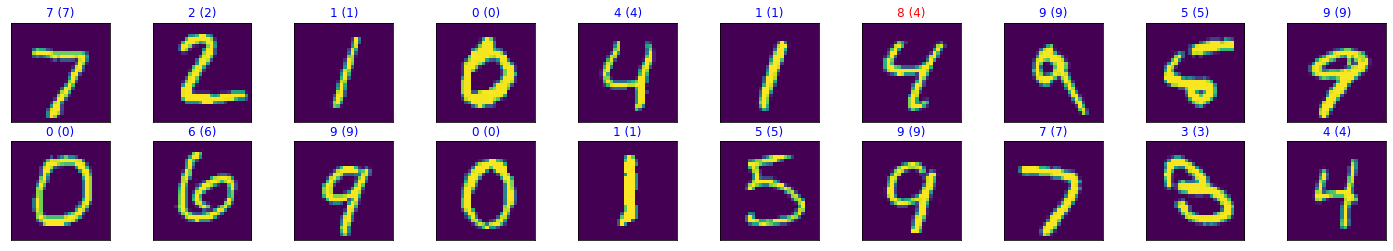

In [22]:
test(model_2)